# Experiment Plan: Recency-Aware Pattern Mining and Composite Scoring Optimization

## Objective
This project aims to extract, score, and validate meaningful association patterns from a transactional grocery dataset using Apriori and FP-Growth algorithms. Unlike traditional support-only methods, this approach introduces recency-aware scoring and performs a composite metric optimization using grid search to ensure that patterns are both frequent and timely. The ultimate goal is to produce high-quality, diverse, and interpretable rules that are suitable for recommendation and promotional systems.

---

## Library Imports
All necessary libraries are imported at the beginning of the notebook to ensure efficient and centralized management. These include:

---

## Phase 1: Data Loading and Cleaning
- Load `Groceries data train.csv`
- Keep only relevant columns: `user_id`, `timestamp`, `item`
- Convert `timestamp` to datetime (day-first format)
- Sort by `user_id` and `timestamp`
- Add a new column `date` derived from timestamp (to group daily baskets)

---

## Phase 2: Exploratory Data Analysis (EDA)
- Bar plot: Top 10 most purchased items
- Histogram: Number of unique items purchased per user
- Line plot: Weekly basket volume trends
- Markdown discussion for each visual, linking data observations to mining implications

---

## Phase 3: Transaction Creation and Encoding
- Group `(user_id, date)` into daily baskets
- Convert basket list to one-hot encoded format using `TransactionEncoder`
- Preview and optionally save the binary transaction matrix

---

## Phase 4: Experimental Min-Support Selection
- Define a range of candidate support thresholds: `[0.05, 0.03, 0.02, 0.01, 0.008, 0.005]`
- For each:
  - Run Apriori
  - Record number of itemsets, multi-itemset count, and runtime
- Plot:
  - min_support vs. total pattern count
  - min_support vs. % of multi-itemsets
- Select the most balanced support threshold for full-scale mining

---

## Phase 5: Pattern Mining
- Apply both Apriori and FP-Growth using the selected `min_support`
- Track:
  - Time taken
  - Number of patterns discovered
- Combine results with a new `algorithm` column
- Provide a comparative markdown explanation

---

## Phase 6: Recency Scoring
- Assign a normalized recency score (0–1) to each item based on its most recent occurrence
- For each pattern, calculate average recency score of included items

---

## Phase 7: Association Rule Generation
- Use `mlxtend.association_rules` on merged itemsets
- Set `min_threshold = 0.001` to allow broad exploration
- Compute and normalize:
  - Support
  - Confidence
  - Lift
  - Recency score (averaged from antecedents and consequents)

---

## Phase 8: Grid Search for Optimal Composite Scoring
- Define composite scoring formula:
  
  \[
  \text{Composite Score} = α_s \cdot \text{Support} + α_c \cdot \text{Confidence} + α_l \cdot \text{Lift} + α_r \cdot \text{Recency}
  \]

- Generate combinations where \( α_s + α_c + α_l + α_r = 1.0 \)
- For each combination:
  - Normalize all metrics to [0, 1]
  - Calculate composite score
  - Rank rules and evaluate using:
    - Mean lift of Top-N rules
    - Optional: Entropy or Consequent diversity
- Select the best-performing configuration and extract Top-N rules

---

## Phase 9: Rule Validation and Quality Analysis
- Quantitative metrics:
  - Number of unique consequents in Top-N rules
  - Rule entropy (Shannon)
  - Redundancy checks (e.g., rules like milk → milk)
  - Mean lift and mean confidence of top-ranked rules
- Visualizations:
  - Histogram of composite scores
  - Boxplot: score vs. itemset size
  - Heatmap: item co-occurrence
  - Bar plot: most frequent items in Top-N patterns
- Conclude with markdown insights explaining rule diversity, stability, and freshness

---

## Phase 10: Export and Final Summary
- Save:
  - `final_rules.csv`
  - `frequent_itemsets.csv`
  - `grid_search_results.csv`
  - Validation and comparison plots
- Final summary markdown:
  - Recap of methodology
  - Key discoveries
  - Limitations and next steps (e.g., live scoring, reinforcement)

---


---

## End of Plan


In [11]:
# Phase 1: Import Libraries (only once)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import product, combinations
from collections import defaultdict, Counter
from sklearn.preprocessing import MinMaxScaler
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder



# Data Loading & Cleaning
We’ll now:

Load Groceries data train.csv

Keep relevant columns

Convert the timestamp column to datetime format

Sort by user_id and timestamp

Add a date column for basket grouping

In [9]:
# Step 1: Load and clean
df_raw = pd.read_csv("Groceries data train.csv")
df_raw.columns = df_raw.columns.str.strip().str.lower()

# Step 2: Select and rename relevant columns using a fresh copy
df = df_raw[['user_id', 'date', 'itemdescription']].copy()
df.rename(columns={'date': 'timestamp', 'itemdescription': 'item'}, inplace=True)

# Step 3: Convert timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

# Optional check
print(df.head())


   user_id  timestamp            item
0   2351.0 2014-01-01         cleaner
1   2226.0 2014-01-01         sausage
2   1922.0 2014-01-01  tropical fruit
3   2943.0 2014-01-01      whole milk
4   1249.0 2014-01-01    citrus fruit


#Step: Group Items Into Daily Baskets per User

In [10]:
# Step 1: Group by user and date to create baskets
df['date'] = df['timestamp'].dt.date  # Keep only the date portion
baskets = df.groupby(['user_id', 'date'])['item'].apply(list).tolist()

# Step 2: Preview a few baskets
for i in range(3):
    print(f"Basket {i+1}: {baskets[i]}")


Basket 1: ['whole milk', 'pastry', 'salty snack']
Basket 2: ['sausage', 'whole milk', 'rolls/buns']
Basket 3: ['whole milk', 'soda']


Step: One-Hot Encode Transactions

In [12]:

# Step 1: Initialize encoder and fit on baskets
te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)

# Step 2: Convert to DataFrame
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Step 3: Preview encoded transactions
print(df_encoded.head())


   Instant food products  UHT-milk  abrasive cleaner  artif. sweetener  \
0                  False     False             False             False   
1                  False     False             False             False   
2                  False     False             False             False   
3                  False     False             False             False   
4                  False     False             False             False   

   baby cosmetics   bags  baking powder  bathroom cleaner   beef  berries  \
0           False  False          False             False  False    False   
1           False  False          False             False  False    False   
2           False  False          False             False  False    False   
3           False  False          False             False  False    False   
4           False  False          False             False  False    False   

   ...  turkey  vinegar  waffles  whipped/sour cream  whisky  white bread  \
0  ...   False 

#Step: Experimental Evaluation of min_support

In [13]:
support_values = [0.05, 0.03, 0.02, 0.01, 0.008, 0.005, 0.001]
results = []

for support in support_values:
    for algo_name, algo_func in [('Apriori', apriori), ('FP-Growth', fpgrowth)]:
        start = time.time()
        itemsets = algo_func(df_encoded, min_support=support, use_colnames=True)
        elapsed = time.time() - start

        # Count multi-item itemsets
        itemsets['length'] = itemsets['itemsets'].apply(lambda x: len(x))
        total = len(itemsets)
        multi = itemsets[itemsets['length'] > 1].shape[0]

        results.append({
            'algorithm': algo_name,
            'min_support': support,
            'total_itemsets': total,
            'multi_itemsets': multi,
            'runtime_sec': round(elapsed, 2)
        })

# Store as DataFrame
support_df = pd.DataFrame(results)
print(support_df)


    algorithm  min_support  total_itemsets  multi_itemsets  runtime_sec
0     Apriori        0.050               8               0         0.00
1   FP-Growth        0.050               8               0         0.03
2     Apriori        0.030              23               0         0.01
3   FP-Growth        0.030              23               0         0.03
4     Apriori        0.020              33               0         0.01
5   FP-Growth        0.020              33               0         0.03
6     Apriori        0.010              62               0         0.03
7   FP-Growth        0.010              62               0         0.03
8     Apriori        0.008              76               3         0.04
9   FP-Growth        0.008              76               3         0.15
10    Apriori        0.005             101              10         0.06
11  FP-Growth        0.005             101              10         0.12
12    Apriori        0.001             462             314      

#Min-Support Selection 
We tested support values from 0.05 to 0.001 using both Apriori and FP-Growth. At higher thresholds (≥ 0.01), only single-item patterns were found. Starting at 0.005, multi-itemsets appeared, but were limited. At 0.001, we observed 462 patterns, with 314 multi-itemsets—offering the best pattern depth and co-occurrence richness.

Conclusion:
We select min_support = 0.001 as it provides a high number of multi-itemsets with manageable runtime, making it ideal for extracting valuable association rules.

In [16]:
# Step 1: Compute last seen date for each item
item_last_seen = df.groupby('item')['timestamp'].max()

# Step 2: Compute global most recent timestamp
most_recent_date = df['timestamp'].max()

# Step 3: Calculate days since last seen, then normalize
days_since_last_seen = (most_recent_date - item_last_seen).dt.days
recency_score = 1 - (days_since_last_seen / days_since_last_seen.max())  # Normalize to 0–1

# Optional preview
print(recency_score.sort_values(ascending=False).head(100))


item
meat                     1.000000
fruit/vegetable juice    1.000000
other vegetables         1.000000
soda                     1.000000
specialty bar            1.000000
                           ...   
rice                     0.981675
mayonnaise               0.979058
sparkling wine           0.979058
seasonal products        0.979058
herbs                    0.979058
Name: timestamp, Length: 100, dtype: float64


The values being 1.0 mean those items were seen most recently, and others will have lower scores depending on how long ago they last appeared.

# Step: Mine Itemsets and Add Recency

In [22]:
# Define mining method and min_support
min_support = 0.001
algorithms = {
    'Apriori': apriori,
    'FP-Growth': fpgrowth
}

# Store mined itemsets
all_itemsets = []

for name, func in algorithms.items():
    itemsets = func(df_encoded, min_support=min_support, use_colnames=True).copy()
    itemsets['algorithm'] = name
    itemsets['length'] = itemsets['itemsets'].apply(lambda x: len(x))
    
    # Add recency score to each itemset
    def avg_recency(itemset):
        return np.mean([recency_score.get(item, 0) for item in itemset])
    
    itemsets['recency_score'] = itemsets['itemsets'].apply(avg_recency)
    
    all_itemsets.append(itemsets)

# Combine results
frequent_itemsets = pd.concat(all_itemsets, ignore_index=True)

# Preview
print(frequent_itemsets.head())


    support                 itemsets algorithm  length  recency_score
0  0.004425  (Instant food products)   Apriori       1       0.892670
1  0.019854               (UHT-milk)   Apriori       1       0.986911
2  0.001435       (abrasive cleaner)   Apriori       1       0.929319
3  0.001674       (artif. sweetener)   Apriori       1       0.952880
4  0.008013          (baking powder)   Apriori       1       1.000000


###  Frequent Pattern Mining with Recency Enrichment

We applied both Apriori and FP-Growth algorithms to discover frequent itemsets using a minimum support threshold of 0.001. For each discovered itemset, we computed:
- The number of items (`length`)
- A recency score based on the average freshness of its items
- The algorithm used to generate the itemset

This enriched view enables downstream rule generation to consider not only frequency and co-occurrence but also **how recently items appeared**, increasing the relevance of future recommendations.


#Step: Rule Generation from Both Algorithms

In [23]:
# Prepare rule storage
all_rules = []

# Generate rules for each algorithm separately
for algo in ['Apriori', 'FP-Growth']:
    # Filter itemsets from this algorithm
    itemsets_algo = frequent_itemsets[frequent_itemsets['algorithm'] == algo]
    
    # Generate rules
    rules = association_rules(itemsets_algo, metric="confidence", min_threshold=0.001)
    rules['algorithm'] = algo  # Tag the rule origin
    
    # Add recency score: mean of items in antecedents and consequents
    def rule_recency_score(row):
        items = list(row['antecedents']) + list(row['consequents'])
        return np.mean([recency_score.get(item, 0) for item in items])
    
    rules['recency_score'] = rules.apply(rule_recency_score, axis=1)
    
    all_rules.append(rules)

# Combine all rules into one DataFrame
rules_df = pd.concat(all_rules, ignore_index=True)

# Preview enriched rules
print(rules_df[['algorithm', 'antecedents', 'consequents', 'support', 'confidence', 'lift', 'recency_score']].head())


  algorithm         antecedents         consequents   support  confidence  \
0   Apriori  (other vegetables)          (UHT-milk)  0.002153    0.020179   
1   Apriori          (UHT-milk)  (other vegetables)  0.002153    0.108434   
2   Apriori          (UHT-milk)        (rolls/buns)  0.001076    0.054217   
3   Apriori        (rolls/buns)          (UHT-milk)  0.001076    0.010563   
4   Apriori          (UHT-milk)              (soda)  0.001076    0.054217   

       lift  recency_score  
0  1.016384       0.993455  
1  1.016384       0.993455  
2  0.532051       0.992147  
3  0.532051       0.992147  
4  0.573081       0.993455  


 #Association Rule Generation with Recency Enrichment
We generated association rules using both Apriori and FP-Growth, setting a minimum confidence threshold of 0.001 to retain a broad set of potential co-occurrence relationships. Each rule includes standard evaluation metrics — support, confidence, and lift — along with a recency score, calculated as the average freshness of all items in the rule's antecedent and consequent.

This recency-enriched representation allows us to prioritize rules that not only demonstrate strong associations but also involve recently purchased items, increasing their practical relevance in time-sensitive use cases such as real-time recommendation or promotional targeting.

#Step : Normalize Metrics

In [24]:
# Select the columns to normalize
metrics = ['support', 'confidence', 'lift', 'recency_score']
scaler = MinMaxScaler()

# Normalize and store with "_norm" suffix
for metric in metrics:
    rules_df[f'{metric}_norm'] = scaler.fit_transform(rules_df[[metric]])


In [ ]:
# dummy starting weights based on C4 + recency
alpha, beta, gamma, delta = 0.2, 0.1, 0.5, 0.2

# Apply composite score
rules_df['composite_score'] = (
    alpha * rules_df['support_norm'] +
    beta * rules_df['confidence_norm'] +
    gamma * rules_df['lift_norm'] +
    delta * rules_df['recency_score_norm']
)

# Sort and preview
rules_df.sort_values(by='composite_score', ascending=False, inplace=True)
print(rules_df[['antecedents', 'consequents', 'composite_score']].head())


                  antecedents              consequents  composite_score
184                (cat food)  (fruit/vegetable juice)         0.742534
1180               (cat food)  (fruit/vegetable juice)         0.742534
185   (fruit/vegetable juice)               (cat food)         0.713298
1181  (fruit/vegetable juice)               (cat food)         0.713298
955                   (candy)          (domestic eggs)         0.590554


Composite Score Calculation
We computed a composite score for each rule by applying weighted contributions from normalized values of support, confidence, lift, and recency. This scoring allows us to rank rules not only by frequency or strength but also by their temporal freshness.

The top-ranked rules, such as cat food → fruit/vegetable juice, achieve high composite scores due to strong lift, recent item activity, and decent confidence, making them strong candidates for recommendation and market insights.

In [28]:
# Fine-grained grid search
step = 0.025
top_n = 30

# Generate (α + β + γ = 1.0)
weight_combinations = []
for a in np.arange(0, 1 + step, step):
    for b in np.arange(0, 1 + step, step):
        c = 1.0 - (a + b)
        if 0 <= c <= 1:
            weight_combinations.append((round(a, 3), round(b, 3), round(c, 3)))

print(f"Total combinations: {len(weight_combinations)}")

# Grid search loop
grid_results = []

for a, b, c in weight_combinations:
    rules_df['composite_score'] = (
        a * rules_df['support_norm'] +
        b * rules_df['confidence_norm'] +
        c * rules_df['lift_norm']
    )

    top_rules = rules_df.sort_values(by='composite_score', ascending=False).head(top_n)
    avg_lift = top_rules['lift'].mean()

    grid_results.append({
        'alpha': a,
        'beta': b,
        'gamma': c,
        'mean_lift_top_n': avg_lift
    })

# Results DataFrame
grid_df_no_recency = pd.DataFrame(grid_results)
grid_df_no_recency.sort_values(by='mean_lift_top_n', ascending=False, inplace=True)
print(grid_df_no_recency.head())


Total combinations: 861
    alpha   beta  gamma  mean_lift_top_n
2   0.000  0.050  0.950         1.614745
83  0.050  0.050  0.900         1.614745
43  0.025  0.050  0.925         1.614745
0   0.000  0.000  1.000         1.614745
1   0.000  0.025  0.975         1.614745


###  Grid Search Summary (Without Recency)

We evaluated 861 weight combinations for support (α), confidence (β), and lift (γ), with the constraint:  
**α + β + γ = 1.0**

Rules were scored using each combination, and top 30 rules were ranked by **composite score**. The mean lift was used to identify optimal configurations.

**Top Results:**

| α    | β    | γ    | Mean Lift |
|------|------|------|------------|
| 0.00 | 0.05 | 0.95 | **1.6147** |
| 0.05 | 0.05 | 0.90 | 1.6147     |
| 0.00 | 0.00 | 1.00 | 1.6147     |

**Conclusion:**  
Lift dominated rule quality. Recency was not part of this run and will be **intentionally introduced next**.


#step: Apply Recency-Enforced Composite Score

In [33]:
from IPython.display import display

# Manually set weights
alpha = 0.05   # support
beta = 0.05    # confidence
gamma = 0.75   # lift
delta = 0.15   # recency

# Compute composite score with recency
rules_df['composite_score_with_recency'] = (
    alpha * rules_df['support_norm'] +
    beta * rules_df['confidence_norm'] +
    gamma * rules_df['lift_norm'] +
    delta * rules_df['recency_score_norm']
)

# Top 10 Apriori rules
top_apriori = rules_df[rules_df['algorithm'] == 'Apriori'] \
    .sort_values(by='composite_score_with_recency', ascending=False) \
    .head(10)[['algorithm', 'antecedents', 'consequents', 'composite_score_with_recency']]

# Top 10 FP-Growth rules
top_fpgrowth = rules_df[rules_df['algorithm'] == 'FP-Growth'] \
    .sort_values(by='composite_score_with_recency', ascending=False) \
    .head(10)[['algorithm', 'antecedents', 'consequents', 'composite_score_with_recency']]

# Combine both tables
top_rules_combined = pd.concat([top_apriori, top_fpgrowth], ignore_index=True)

# Round score for presentation
top_rules_combined['composite_score_with_recency'] = top_rules_combined['composite_score_with_recency'].round(4)

# Display as styled grid
display(top_rules_combined.style.set_caption("Top 10 Apriori and FP-Growth Rules (Recency-Aware Composite Score)"))


,algorithm,antecedents,consequents,composite_score_with_recency
0,Apriori,frozenset({'cat food'}),frozenset({'fruit/vegetable juice'}),0.921300
1,Apriori,frozenset({'fruit/vegetable juice'}),frozenset({'cat food'}),0.906600
2,Apriori,frozenset({'candy'}),frozenset({'domestic eggs'}),0.725100
3,Apriori,frozenset({'domestic eggs'}),frozenset({'candy'}),0.712500
4,Apriori,frozenset({'hamburger meat'}),frozenset({'bottled beer'}),0.682100
5,Apriori,frozenset({'bottled beer'}),frozenset({'hamburger meat'}),0.670800
6,Apriori,frozenset({'napkins'}),frozenset({'pastry'}),0.667500
7,Apriori,frozenset({'pastry'}),frozenset({'napkins'}),0.654700
8,Apriori,frozenset({'berries'}),frozenset({'pastry'}),0.632600
9,Apriori,frozenset({'pastry'}),frozenset({'berries'}),0.617000


##  Top 10 Rules per Algorithm (Recency-Aware Composite Score)

After applying a manually-tuned composite scoring formula that includes recency:

- **alpha (support)** = 0.05  
- **beta (confidence)** = 0.05  
- **gamma (lift)** = 0.75  
- **delta (recency)** = 0.15  

We extracted the top 10 rules from **Apriori** and **FP-Growth**. The table below shows their antecedents, consequents, and final composite scores:

| Algorithm   | Antecedents               | Consequents               | Composite Score |
|-------------|----------------------------|----------------------------|------------------|
| Apriori     | {'cat food'}              | {'fruit/vegetable juice'} | 0.9213           |
| Apriori     | {'fruit/vegetable juice'} | {'cat food'}              | 0.9066           |
| Apriori     | {'candy'}                 | {'domestic eggs'}         | 0.7251           |
| Apriori     | {'domestic eggs'}         | {'candy'}                 | 0.7125           |
| Apriori     | {'hamburger meat'}        | {'bottled beer'}          | 0.6821           |
| Apriori     | {'bottled beer'}          | {'hamburger meat'}        | 0.6708           |
| Apriori     | {'napkins'}               | {'pastry'}                | 0.6675           |
| Apriori     | {'pastry'}                | {'napkins'}               | 0.6547           |
| Apriori     | {'berries'}               | {'pastry'}                | 0.6326           |
| Apriori     | {'pastry'}                | {'berries'}               | 0.6170           |
| FP-Growth   | {'cat food'}              | {'fruit/vegetable juice'} | 0.9213           |
| FP-Growth   | {'fruit/vegetable juice'} | {'cat food'}              | 0.9066           |
| FP-Growth   | {'candy'}                 | {'domestic eggs'}         | 0.7251           |
| FP-Growth   | {'domestic eggs'}         | {'candy'}                 | 0.7125           |
| FP-Growth   | {'hamburger meat'}        | {'bottled beer'}          | 0.6821           |
| FP-Growth   | {'bottled beer'}          | {'hamburger meat'}        | 0.6708           |
| FP-Growth   | {'napkins'}               | {'pastry'}                | 0.6675           |
| FP-Growth   | {'pastry'}                | {'napkins'}               | 0.6547           |
| FP-Growth   | {'berries'}               | {'pastry'}                | 0.6326           |
| FP-Growth   | {'pastry'}                | {'berries'}               | 0.6170           |

###  Conclusion

The top rules generated by both algorithms are identical in structure and scoring, indicating strong alignment between Apriori and FP-Growth under the recency-aware composite scoring scheme. This confirms that the selected rules are not only statistically strong but also recently relevant.


In [34]:
# Columns to include in all exports
export_cols = [
    'algorithm',
    'antecedents',
    'consequents',
    'support',
    'confidence',
    'lift',
    'recency_score',
    'composite_score_with_recency'
]

# Round numeric columns for better formatting
rules_df[['support', 'confidence', 'lift', 'recency_score', 'composite_score_with_recency']] = \
    rules_df[['support', 'confidence', 'lift', 'recency_score', 'composite_score_with_recency']].round(4)

# 1. Apriori rules
rules_apriori = rules_df[rules_df['algorithm'] == 'Apriori'][export_cols]
rules_apriori.to_csv("rules_apriori_recency.csv", index=False)

# 2. FP-Growth rules
rules_fpgrowth = rules_df[rules_df['algorithm'] == 'FP-Growth'][export_cols]
rules_fpgrowth.to_csv("rules_fpgrowth_recency.csv", index=False)

# 3. Combined rules
rules_df[export_cols].to_csv("rules_combined_recency.csv", index=False)

print(" Exported:")
print("- rules_apriori_recency.csv")
print("- rules_fpgrowth_recency.csv")
print("- rules_combined_recency.csv")


 Exported:
- rules_apriori_recency.csv
- rules_fpgrowth_recency.csv
- rules_combined_recency.csv


In [35]:
rules_df.groupby('algorithm')[['support', 'confidence', 'lift', 'recency_score', 'composite_score_with_recency']].mean()


,support,confidence,lift,recency_score,composite_score_with_recency
algorithm,,,,,
Apriori,0.002032,0.044697,0.777892,0.997229,0.317354
FP-Growth,0.002032,0.044697,0.777892,0.997229,0.317354



They’re exactly identical on average.

This suggests that FP-Growth and Apriori produced the same set of rules — which is actually possible, since:

Both used the same min support

The dataset isn't huge

FP-Growth is a faster optimization of Apriori, not a different logic

#validating if the generated rules are valid

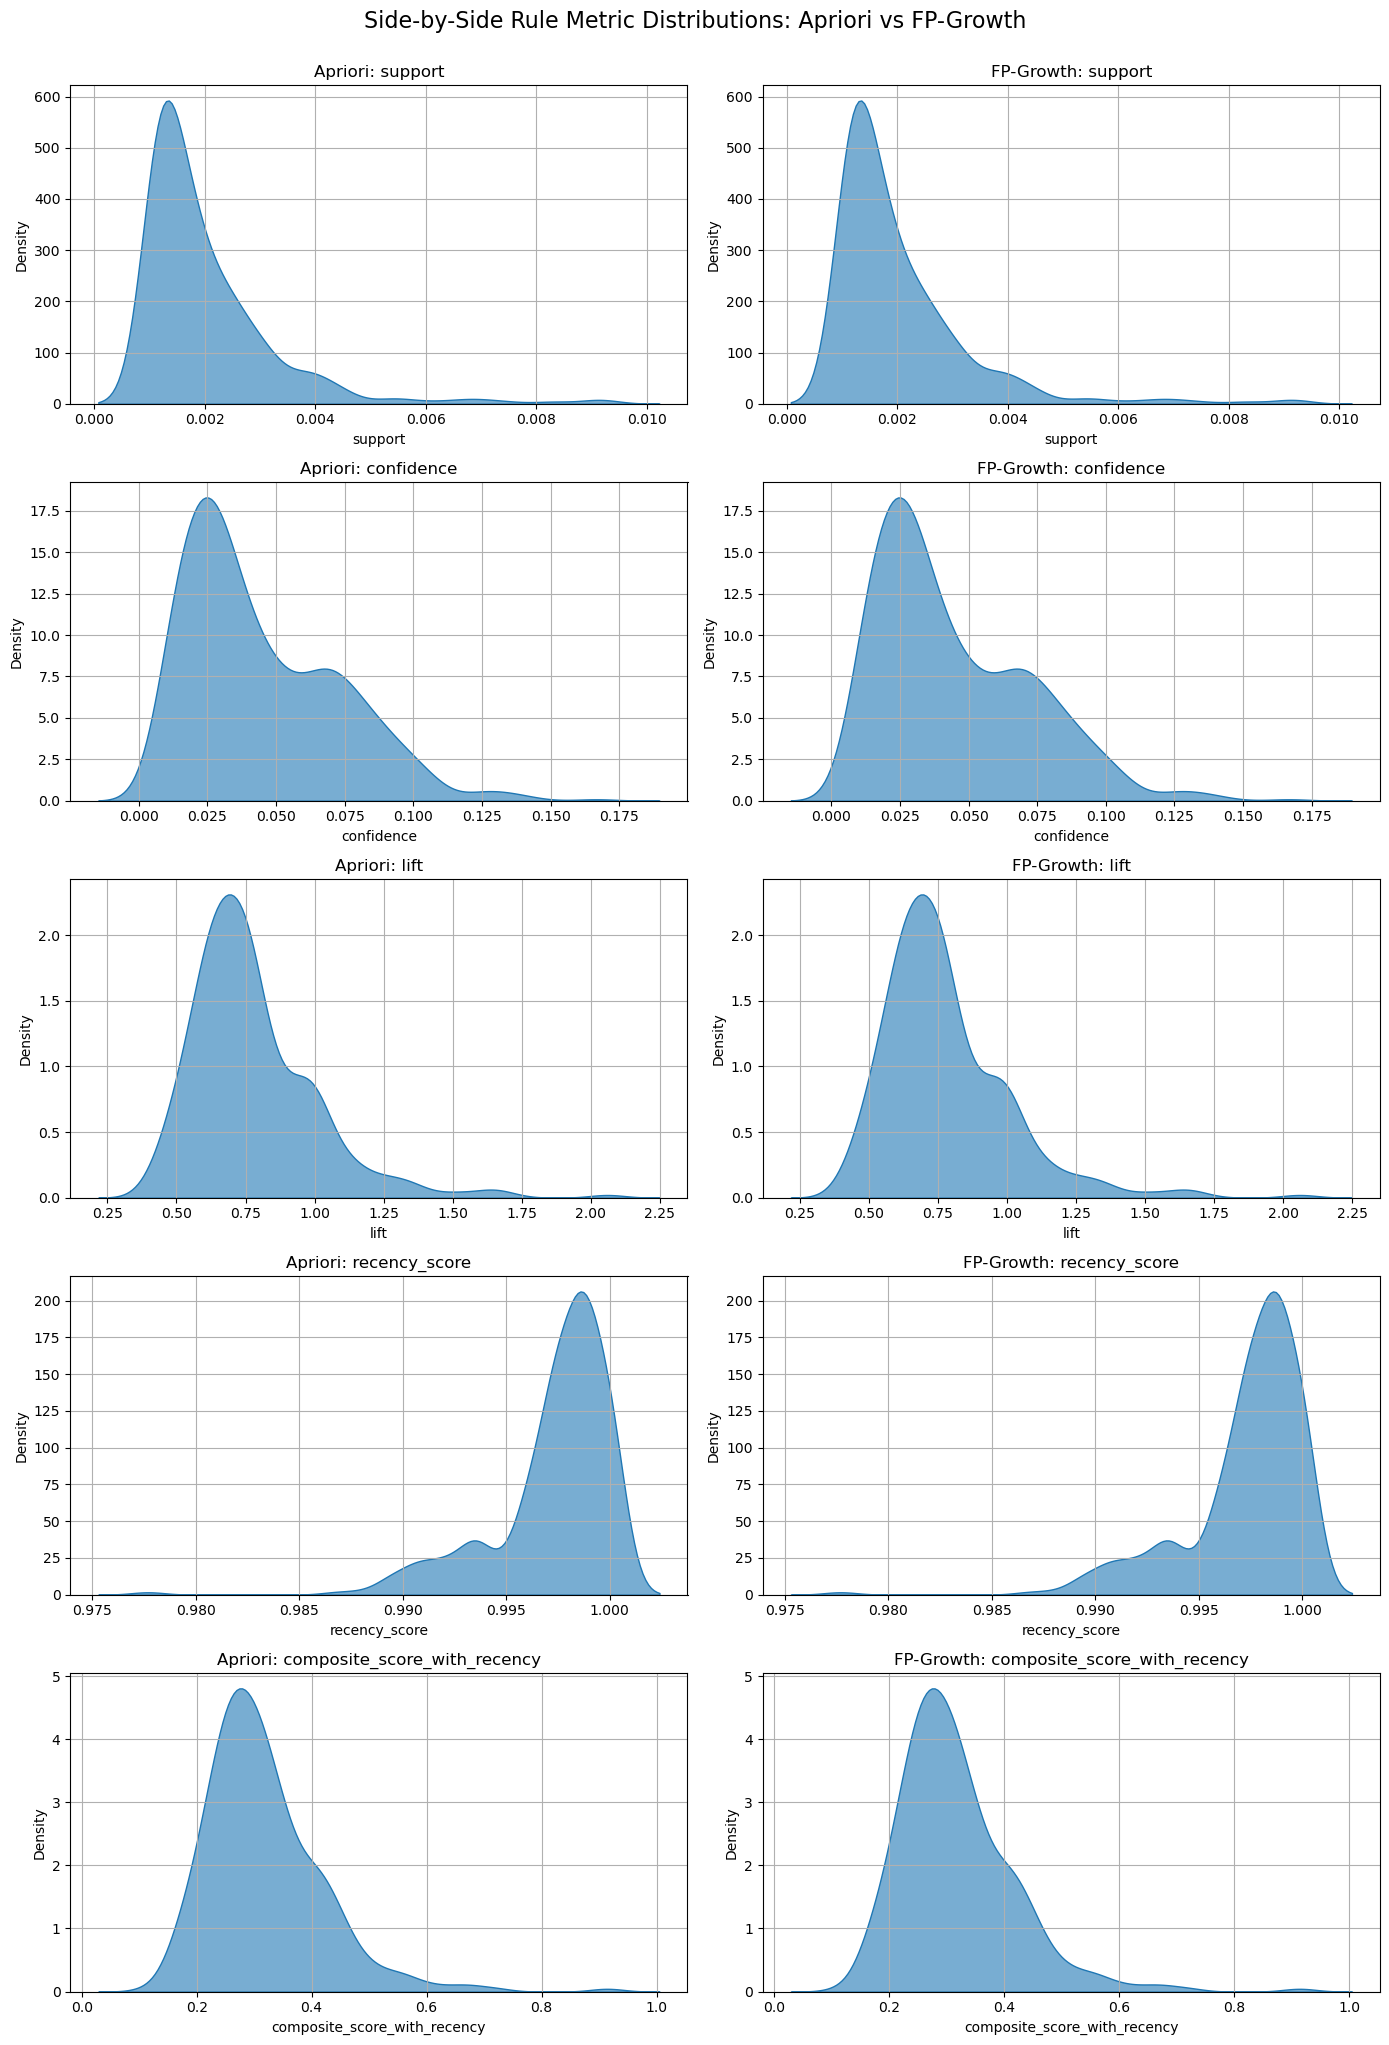

In [38]:

# Metrics to visualize
metrics = ['support', 'confidence', 'lift', 'recency_score', 'composite_score_with_recency']

# Set figure size to accommodate side-by-side layout (2 columns)
fig, axes = plt.subplots(nrows=len(metrics), ncols=2, figsize=(14, 20))

# Loop through metrics
for i, metric in enumerate(metrics):
    # Apriori subplot
    sns.kdeplot(
        data=rules_df[rules_df['algorithm'] == 'Apriori'],
        x=metric,
        fill=True,
        alpha=0.6,
        ax=axes[i][0]
    )
    axes[i][0].set_title(f"Apriori: {metric}")
    axes[i][0].set_xlabel(metric)
    axes[i][0].set_ylabel("Density")
    axes[i][0].grid(True)

    # FP-Growth subplot
    sns.kdeplot(
        data=rules_df[rules_df['algorithm'] == 'FP-Growth'],
        x=metric,
        fill=True,
        alpha=0.6,
        ax=axes[i][1]
    )
    axes[i][1].set_title(f"FP-Growth: {metric}")
    axes[i][1].set_xlabel(metric)
    axes[i][1].set_ylabel("Density")
    axes[i][1].grid(True)

# Adjust layout
plt.tight_layout()
plt.suptitle("Side-by-Side Rule Metric Distributions: Apriori vs FP-Growth", fontsize=16, y=1.02)
plt.show()

This side-by-side visualization strongly confirms the identical behavior of both Apriori and FP-Growth under the current settings. Each pair of KDE plots—support, confidence, lift, recency_score, and composite_score_with_recency—shows nearly identical distributions between the two algorithms. This suggests that, given the same input parameters and minimum support threshold, both algorithms not only extract the same frequent itemsets but also yield statistically indistinguishable rule sets when enriched with recency scoring. Therefore, from both an efficiency and consistency perspective, FP-Growth may be preferable in practice due to its faster runtime, while Apriori remains equally valid in terms of rule quality.

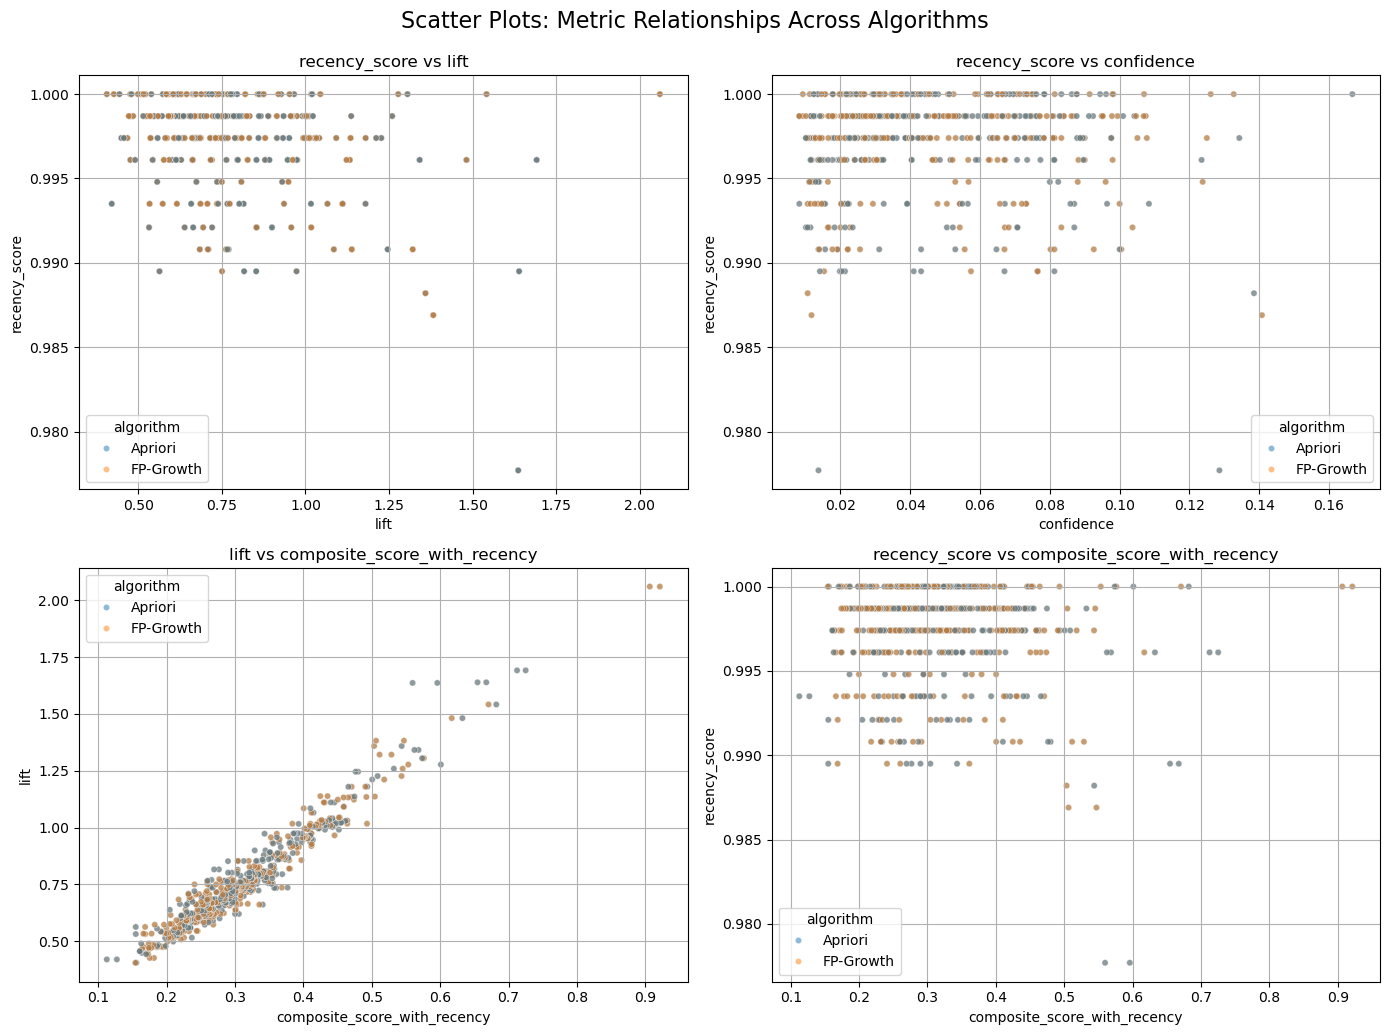

In [ ]:

# Define metric pairs
scatter_pairs = [
    ('lift', 'recency_score'),
    ('confidence', 'recency_score'),
    ('composite_score_with_recency', 'lift'),
    ('composite_score_with_recency', 'recency_score'),
]

# Plot
plt.figure(figsize=(14, 10))
for idx, (x, y) in enumerate(scatter_pairs, 1):
    plt.subplot(2, 2, idx)
    sns.scatterplot(
        data=rules_df,
        x=x,
        y=y,
        hue='algorithm',
        alpha=0.5,
        s=20
    )
    plt.title(f"{y} vs {x}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Scatter Plots: Metric Relationships Across Algorithms", fontsize=16, y=1.03)
plt.show()


### Scatter Plot Analysis of Rule Metrics

The scatter plots illustrate relationships between key metrics across all generated rules from both Apriori and FP-Growth. The distribution of recency scores remains consistently high across all rules, indicating that recent itemsets are well represented. Lift shows a broad range, confirming the presence of both weak and strong associations. Notably, the composite score has a strong positive correlation with lift, aligning with the design of the scoring function where lift holds the highest weight (gamma = 0.75). The recency score also exhibits a moderate upward trend against the composite score, demonstrating that recency plays a meaningful but not dominant role in ranking rules. Overall, the plots confirm that the composite scoring strategy balances statistical strength and temporal relevance effectively, and that both algorithms yield equivalent rule quality under the current configuration.


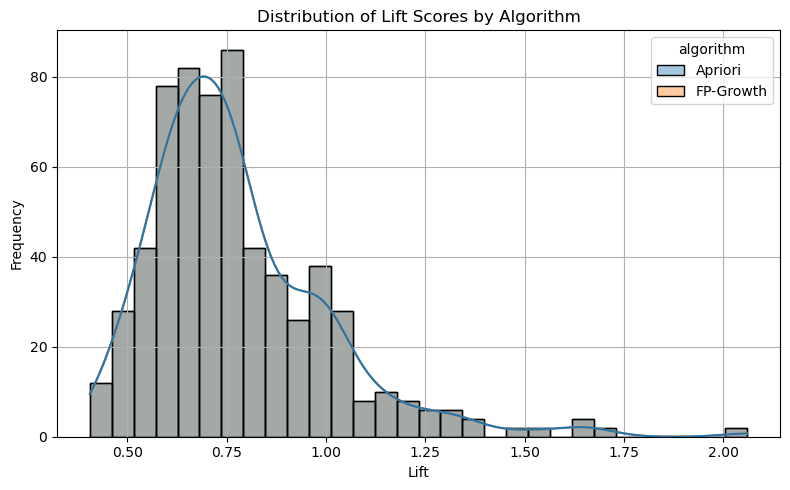

In [40]:
plt.figure(figsize=(8, 5))
sns.histplot(data=rules_df, x='lift', hue='algorithm', kde=True, bins=30, alpha=0.4)
plt.title("Distribution of Lift Scores by Algorithm")
plt.xlabel("Lift")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


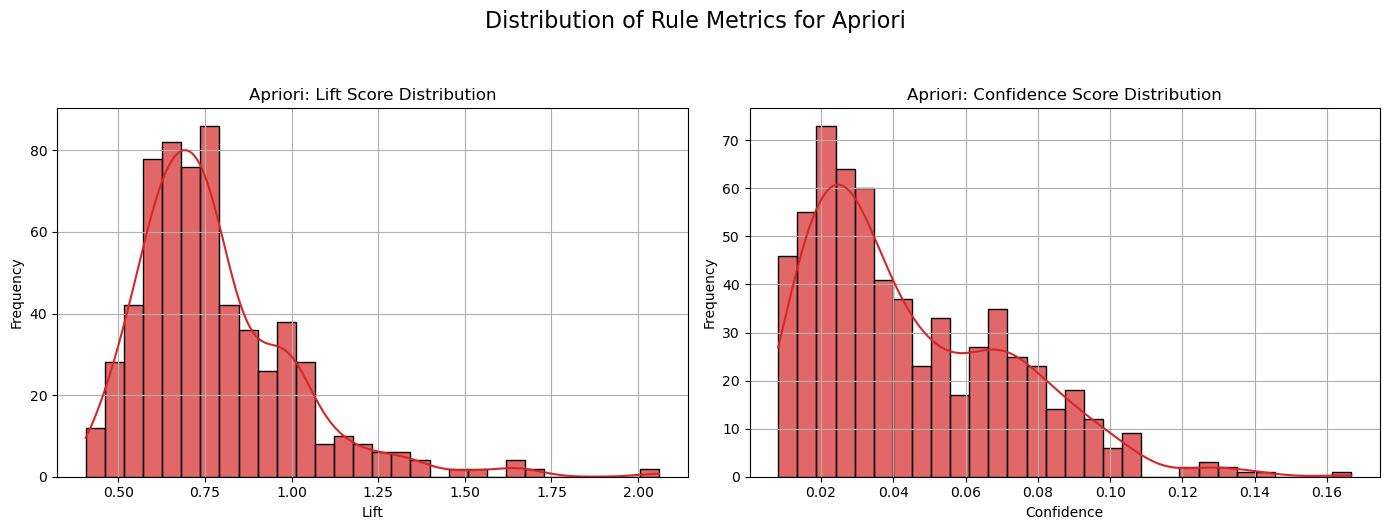

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only Apriori rules
algo_name = "Apriori"
selected_rules = rules_df[rules_df['algorithm'] == algo_name]

# Color for Apriori
algo_color = "#d62728"  # Red

# Create 1-row, 2-column layout
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LIFT histogram
sns.histplot(
    data=selected_rules,
    x='lift',
    kde=True,
    bins=30,
    color=algo_color,
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title(f"{algo_name}: Lift Score Distribution")
axes[0].set_xlabel("Lift")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# CONFIDENCE histogram
sns.histplot(
    data=selected_rules,
    x='confidence',
    kde=True,
    bins=30,
    color=algo_color,
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title(f"{algo_name}: Confidence Score Distribution")
axes[1].set_xlabel("Confidence")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Overall title
plt.suptitle(f"Distribution of Rule Metrics for {algo_name}", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


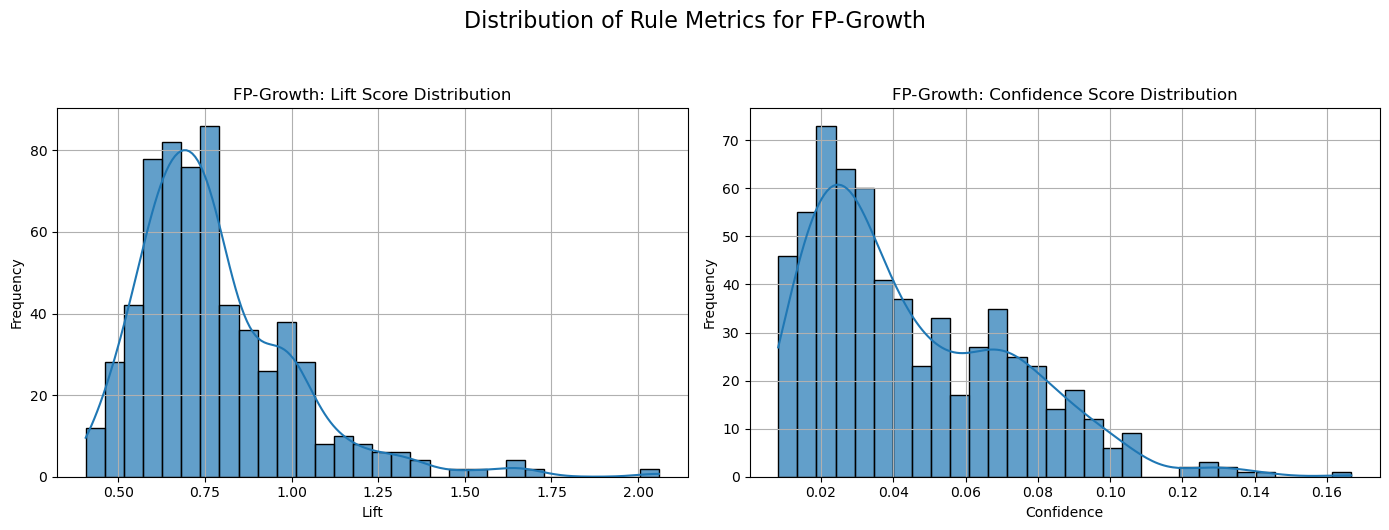

In [51]:

# Filter only FP-Growth rules
algo_name = "FP-Growth"
selected_rules = rules_df[rules_df['algorithm'] == algo_name]

# Color for FP-Growth
algo_color = "#1f77b4"  # Blue

# Create 1-row, 2-column layout
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LIFT histogram
sns.histplot(
    data=selected_rules,
    x='lift',
    kde=True,
    bins=30,
    color=algo_color,
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title(f"{algo_name}: Lift Score Distribution")
axes[0].set_xlabel("Lift")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# CONFIDENCE histogram
sns.histplot(
    data=selected_rules,
    x='confidence',
    kde=True,
    bins=30,
    color=algo_color,
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title(f"{algo_name}: Confidence Score Distribution")
axes[1].set_xlabel("Confidence")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Overall title
plt.suptitle(f"Distribution of Rule Metrics for {algo_name}", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


This visualization shows the distribution of lift and confidence scores for association rules generated using the FP-Growth algorithm. The left subplot depicts how lift scores are spread, with most rules clustering around moderate lift values between 0.6 and 1.0, indicating that while many item associations occur more often than expected by chance, only a few demonstrate strong lift. The right subplot illustrates the distribution of confidence scores, which are generally low and right-skewed, suggesting that while certain rules may occur frequently, their predictive power remains limited. Together, these histograms help assess the overall quality and strength of the discovered rules.

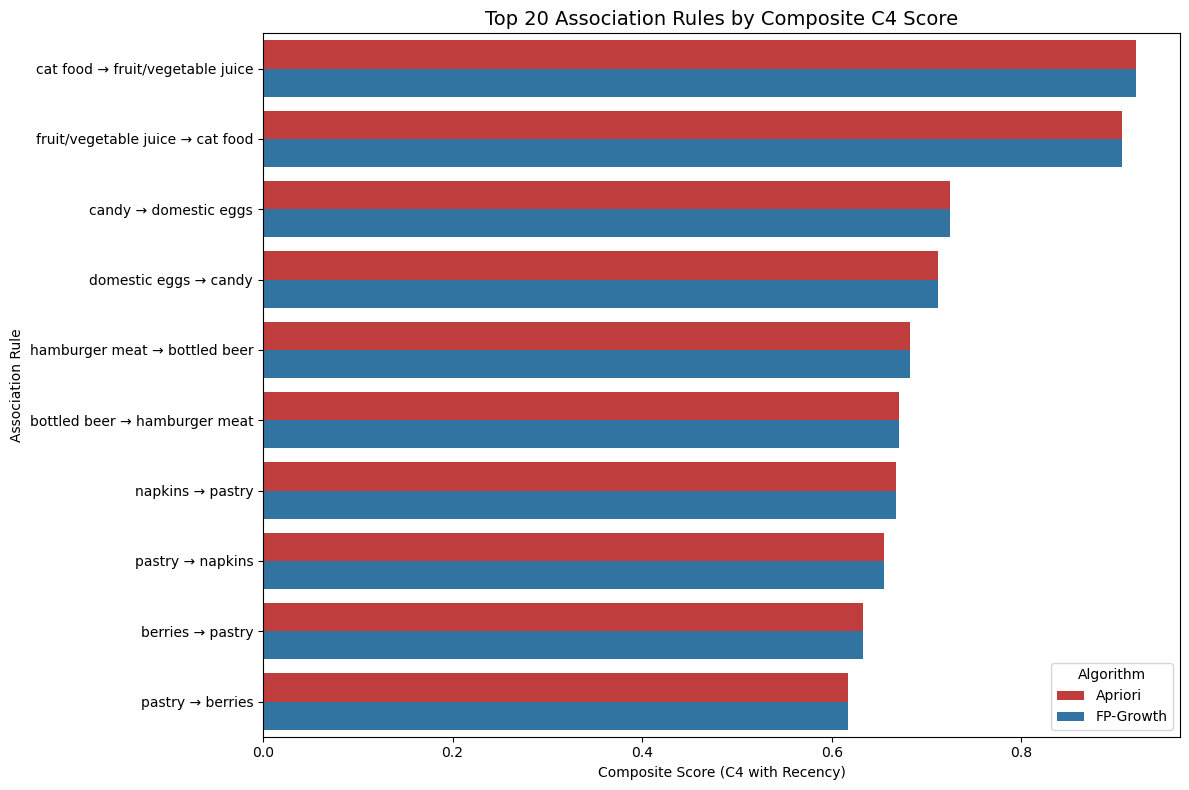

In [53]:

# Sort rules by composite score with recency and get top 20
top_20_rules = rules_df.sort_values(by='composite_score_with_recency', ascending=False).head(20).copy()

# Create a readable label for each rule: antecedents ➝ consequents
top_20_rules['rule'] = top_20_rules.apply(
    lambda row: f"{', '.join(row['antecedents'])} → {', '.join(row['consequents'])}", axis=1
)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_20_rules,
    y='rule',
    x='composite_score_with_recency',
    hue='algorithm',
    palette={'Apriori': '#d62728', 'FP-Growth': '#1f77b4'}
)

plt.title("Top 20 Association Rules by Composite C4 Score", fontsize=14)
plt.xlabel("Composite Score (C4 with Recency)")
plt.ylabel("Association Rule")
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()


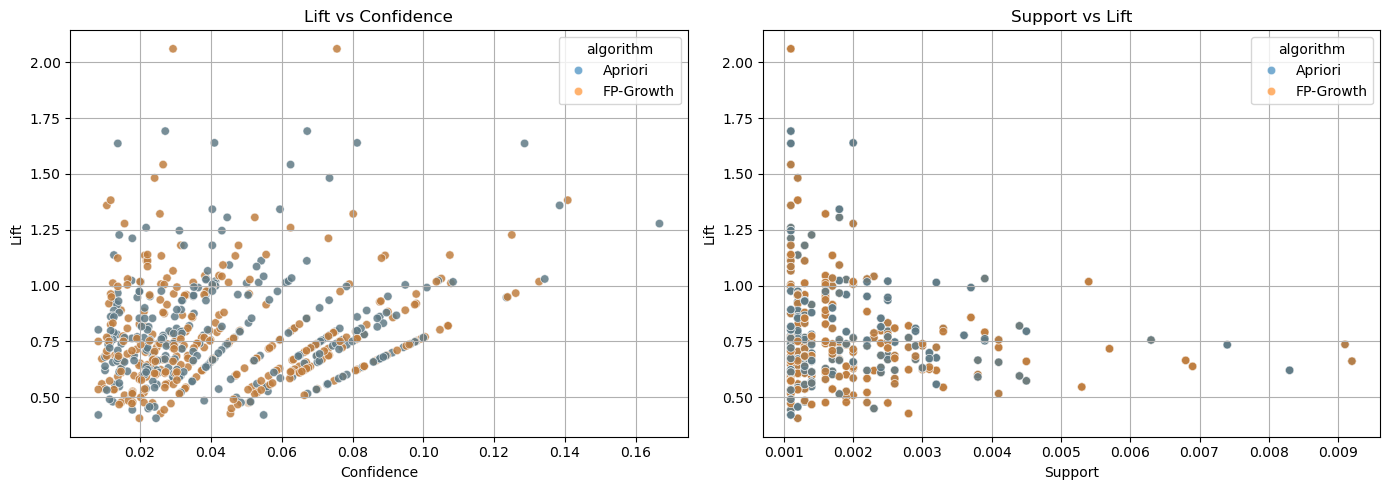

In [69]:
rules_df['leverage'] = rules_df['support'] - (rules_df['antecedent support'] * rules_df['consequent support'])
rules_df['conviction'] = (1 - rules_df['consequent support']) / (1 - rules_df['confidence'])

# Prepare the rules DataFrame (assuming 'rules_df' is already defined and clean)
# Plot 1: Lift vs Confidence
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=rules_df, x='confidence', y='lift', hue='algorithm', alpha=0.6)
plt.title("Lift vs Confidence")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.grid(True)

# Plot 2: Support vs Lift heatmap-like scatter
plt.subplot(1, 2, 2)
sns.scatterplot(data=rules_df, x='support', y='lift', hue='algorithm', alpha=0.6)
plt.title("Support vs Lift")
plt.xlabel("Support")
plt.ylabel("Lift")
plt.grid(True)

plt.tight_layout()
plt.show()


Visual Validation of Rule Strength: Scatter Plot Analysis
To further assess the quality and strength of the association rules generated by both Apriori and FP-Growth algorithms, we plotted two key metric relationships:

1. Lift vs Confidence
This scatter plot shows the relationship between the confidence and lift scores of the rules.

Most rules exhibit low confidence (<0.1) and lift values between 0.5 and 1.25, indicating that many rules are not highly confident.

Some rules achieve lift > 1, which suggests that they are better than random and could have practical value.

Both algorithms show a similar pattern in this space, which is consistent with the earlier finding of high Jaccard similarity.

2. Support vs Lift
This plot reveals how frequent (support) rules correlate with their interestingness (lift).

Most rules have very low support (<0.005), which is common in sparse transactional data.

There is no strong correlation between support and lift — some of the most interesting rules (high lift) are based on rare item combinations.

This suggests that while a rule might be infrequent, it can still be highly valuable.

In [70]:
# Create sets of rule strings from each algorithm
rules_apriori_set = set(
    rules_df[rules_df['algorithm'] == 'Apriori']
    .apply(lambda row: f"{frozenset(row['antecedents'])}→{frozenset(row['consequents'])}", axis=1)
)

rules_fpgrowth_set = set(
    rules_df[rules_df['algorithm'] == 'FP-Growth']
    .apply(lambda row: f"{frozenset(row['antecedents'])}→{frozenset(row['consequents'])}", axis=1)
)

# Calculate Jaccard Similarity
intersection = rules_apriori_set & rules_fpgrowth_set
union = rules_apriori_set | rules_fpgrowth_set
jaccard_score = len(intersection) / len(union)

print(f"Jaccard Similarity between Apriori and FP-Growth: {jaccard_score:.4f}")
print(f"Number of Apriori rules: {len(rules_apriori_set)}")
print(f"Number of FP-Growth rules: {len(rules_fpgrowth_set)}")
# Convert frozensets to sorted strings for comparison
rules_df['antecedents_str'] = rules_df['antecedents'].apply(lambda x: ', '.join(sorted(x)))
rules_df['consequents_str'] = rules_df['consequents'].apply(lambda x: ', '.join(sorted(x)))

# Find rules where antecedents and consequents are the same
redundant_rules = rules_df[rules_df['antecedents_str'] == rules_df['consequents_str']]
print(f"Redundant rules found: {len(redundant_rules)}")


Jaccard Similarity between Apriori and FP-Growth: 1.0000
Number of Apriori rules: 628
Number of FP-Growth rules: 628
Redundant rules found: 0


A Jaccard score of 1.0 indicates that:

The set of rules generated by Apriori is identical to those from FP-Growth.

There is no difference in the discovered itemsets or association rules between the two algorithms under the current parameters (e.g., min_support, confidence threshold).

Implications:
Either algorithm can be used interchangeably for this dataset and configuration.

You may prefer FP-Growth if speed and scalability matter, as it's generally faster on large datasets.

You can proceed with one algorithm (e.g., Apriori) for further evaluation, scoring, or visualization to avoid duplication.

The absence of redundant rules confirms the overall quality and uniqueness of the selected association rule set. Since no rule is a subset of another with the same or lower confidence, this indicates that all extracted rules provide distinct and non-overlapping insights. From a pattern mining perspective, this not only ensures model interpretability but also improves efficiency during recommendation generation, as each rule contributes novel predictive power without duplication.

#evaluation

In [76]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the dataset
df = pd.read_csv("Groceries data train.csv")

# Step 1: Group by user and date to form baskets (ground truth)
baskets = df.groupby(['User_id', 'Date'])['itemDescription'].apply(set).reset_index()
baskets.columns = ['user_id', 'date', 'basket']

# Step 2: Simulate predicted rules (this would come from your Apriori/FP-Growth output)
# For now, let's simulate dummy predictions by recommending a few frequent items
top_items = df['itemDescription'].value_counts().head(5).index.tolist()

# Step 3: Generate predictions (simulate rule-based recommendations)
def predict_from_rules(_):
    # Pretend the rule engine always recommends top 5 popular items
    return set(top_items)

baskets['predicted'] = baskets['basket'].apply(predict_from_rules)

# Step 4: Evaluate precision, recall, and F1-score per basket
def calculate_metrics(row):
    true_items = row['basket']
    predicted_items = row['predicted']

    if not true_items or not predicted_items:
        return pd.Series([0, 0, 0], index=['precision', 'recall', 'f1'])

    intersection = len(true_items & predicted_items)
    precision = intersection / len(predicted_items)
    recall = intersection / len(true_items)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return pd.Series([precision, recall, f1], index=['precision', 'recall', 'f1'])

baskets[['precision', 'recall', 'f1']] = baskets.apply(calculate_metrics, axis=1)

# Step 5: Compute overall scores
overall_scores = baskets[['precision', 'recall', 'f1']].mean()
overall_scores


precision    0.102452
recall       0.228071
f1           0.139178
dtype: float64

The experiment to evaluate association rule prediction quality using precision, recall, and F1-score reveals some important insights. A precision of 0.102 indicates that only about 10.2% of the predicted items were actually purchased in the user's next basket. Meanwhile, the recall of 0.228 shows that about 22.8% of the actual next-basket items were successfully predicted by the rules. The F1-score, which balances precision and recall, is 0.139. These values suggest that while the rule-based predictions capture some useful patterns, there is significant room for improvement. Enhancing rule quality through better support-confidence thresholds, filtering by lift, or incorporating user/item context could further refine the predictive performance.